In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
%cd /content/drive/MyDrive/locodata_Gtech/

/content/drive/MyDrive/locodata_Gtech


In [10]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import re

In [ ]:
###############################################################################
# User configuration section

# This is the base path to the dataset. If you extracted the dataset to the
# same folder as this file, you don't need to change this
base_path = './rawdata'

# This is the list of data types that we want to save. The options are:
# 'Activity_Flag', 'GroundFrame_GRFs', 'Joint_Angle', 'Joint_Moments',
# 'Joint_Powers', 'Joint_Velocities', 'Raw_EMGs', 'Real_IMUs', 'Virtual_IMUs',
# 'Virtual_Insoles', 'Link_Angle',
# Currently the only standardized names are
# 'Joint_Angle', 'Joint_Velocities', 'Joint_Moments', 'Link_Angle'
data_to_save = ['Joint_Moments', 'Joint_Angle',
                'Joint_Velocities', 'Link_Angle', 'Link_Velocities',"GroundFrame_GRFs"]

###############################################################################
# Don't modify anything below this line

# These are used to convert the activity names to a shorter version
short_activity_names = ['ball_toss', 'curb_down', 'curb_up', 'cutting',
                        'dynamic_walk', 'incline_walk', 'jump', 'lift_weight',
                        'lunges', 'meander', 'normal_walk', 'obstacle_walk',
                        'poses', 'push', 'side_shuffle', 'sit_to_stand',
                        'squats', 'stairs', 'step_ups', 'tire_run',
                        'tug_of_war', 'turn_and_step', 'twister',
                        'walk_backward', 'weighted_walk']

standard_column_names = {

    # Joint Angle
    'hip_flexion_r':'hip_angle_s_r',
    'hip_adduction_r':'hip_angle_f_r',
    'hip_rotation_r':'hip_angle_t_r',
    'knee_angle_r':'knee_angle_s_r',
    'ankle_angle_r':'ankle_angle_s_r',
    'subtalar_angle_r':'ankle_angle_f_r',

    'hip_flexion_l':'hip_angle_s_l',
    'hip_adduction_l':'hip_angle_f_l',
    'hip_rotation_l':'hip_angle_t_l',
    'knee_angle_l':'knee_angle_s_l',
    'ankle_angle_l':'ankle_angle_s_l',
    'subtalar_angle_l':'ankle_angle_f_l',

    # Joint Velocities
    'hip_flexion_velocity_r': 'hip_vel_s_r',
    'hip_adduction_velocity_r': 'hip_vel_f_r',
    'hip_rotation_velocity_r': 'hip_vel_t_r',
    'knee_velocity_r': 'knee_vel_s_r',
    'ankle_velocity_r': 'ankle_vel_s_r',
    'subtalar_velocity_r': 'ankle_vel_f_r',

    'hip_flexion_velocity_l': 'hip_vel_s_l',
    'hip_adduction_velocity_l': 'hip_vel_f_l',
    'hip_rotation_velocity_l': 'hip_vel_t_l',
    'knee_velocity_l': 'knee_vel_s_l',
    'ankle_velocity_l': 'ankle_vel_s_l',
    'subtalar_velocity_l': 'ankle_vel_f_l',

    # Joint Moments
    'hip_flexion_r_moment': 'hip_torque_s_r',
    'hip_adduction_r_moment': 'hip_torque_f_r',
    'hip_rotation_r_moment': 'hip_torque_t_r',
    'knee_angle_r_moment': 'knee_torque_s_r',
    'ankle_angle_r_moment': 'ankle_torque_s_r',
    'subtalar_angle_r_moment': 'ankle_torque_f_r',

    'hip_flexion_l_moment': 'hip_torque_s_l',
    'hip_adduction_l_moment': 'hip_torque_f_l',
    'hip_rotation_l_moment': 'hip_torque_t_l',
    'knee_angle_l_moment': 'knee_torque_s_l',
    'ankle_angle_l_moment': 'ankle_torque_s_l',
    'subtalar_angle_l_moment': 'ankle_torque_f_l',

    # Link Angle
    'pelvis_Y':'pelvis_angle_f',
    'pelvis_Z':'pelvis_angle_s',
    'pelvis_X':'pelvis_angle_t',
    'torso_Y':'torso_angle_f',
    'torso_Z':'torso_angle_s',
    'torso_X':'torso_angle_t',

    'femur_r_Y':'thigh_angle_f_r',
    'femur_r_Z':'thigh_angle_s_r',
    'femur_r_X':'thigh_angle_t_r',
    'tibia_r_Y':'shank_angle_f_r',
    'tibia_r_Z':'shank_angle_s_r',
    'tibia_r_X':'shank_angle_t_r',
    'talus_r_Y':'talus_angle_f_r',
    'talus_r_Z':'talus_angle_s_r',
    'talus_r_X':'talus_angle_t_r',
    'calcn_r_Y':'foot_angle_f_r',
    'calcn_r_Z':'foot_angle_s_r',
    'calcn_r_X':'foot_angle_t_r',
    'toes_r_Y':'toes_angle_f_r',
    'toes_r_Z':'toes_angle_s_r',
    'toes_r_X':'toes_angle_t_r',

    'femur_l_Y':'thigh_angle_f_l',
    'femur_l_Z':'thigh_angle_s_l',
    'femur_l_X':'thigh_angle_t_l',
    'tibia_l_Y':'shank_angle_f_l',
    'tibia_l_Z':'shank_angle_s_l',
    'tibia_l_X':'shank_angle_t_l',
    'talus_l_Y':'talus_angle_f_l',
    'talus_l_Z':'talus_angle_s_l',
    'talus_l_X':'talus_angle_t_l',
    'calcn_l_Y':'foot_angle_f_l',
    'calcn_l_Z':'foot_angle_s_l',
    'calcn_l_X':'foot_angle_t_l',
    'toes_l_Y':'toes_angle_f_l',
    'toes_l_Z':'toes_angle_s_l',
    'toes_l_X':'toes_angle_t_l',

    # Link Velocities
    'pelvis_vel_Y':'pelvis_vel_f',
    'pelvis_vel_Z':'pelvis_vel_s',
    'pelvis_vel_X':'pelvis_vel_t',
    'torso_vel_Y':'torso_vel_f',
    'torso_vel_Z':'torso_vel_s',
    'torso_vel_X':'torso_vel_t',
    'femur_r_vel_Y':'thigh_vel_f_r',
    'femur_r_vel_Z':'thigh_vel_s_r',
    'femur_r_vel_X':'thigh_vel_t_r',
    'tibia_r_vel_Y':'shank_vel_f_r',
    'tibia_r_vel_Z':'shank_vel_s_r',
    'tibia_r_vel_X':'shank_vel_t_r',
    'talus_r_vel_Y':'talus_vel_f_r',
    'talus_r_vel_Z':'talus_vel_s_r',
    'talus_r_vel_X':'talus_vel_t_r',
    'calcn_r_vel_Y':'foot_vel_f_r',
    'calcn_r_vel_Z':'foot_vel_s_r',
    'calcn_r_vel_X':'foot_vel_t_r',
    'toes_r_vel_Y':'toes_vel_f_r',
    'toes_r_vel_Z':'toes_vel_s_r',
    'toes_r_vel_X':'toes_vel_t_r',

    'femur_l_vel_Y':'thigh_vel_f_l',
    'femur_l_vel_Z':'thigh_vel_s_l',
    'femur_l_vel_X':'thigh_vel_t_l',
    'tibia_l_vel_Y':'shank_vel_f_l',
    'tibia_l_vel_Z':'shank_vel_s_l',
    'tibia_l_vel_X':'shank_vel_t_l',
    'talus_l_vel_Y':'talus_vel_f_l',
    'talus_l_vel_Z':'talus_vel_s_l',
    'talus_l_vel_X':'talus_vel_t_l',
    'calcn_l_vel_Y':'foot_vel_f_l',
    'calcn_l_vel_Z':'foot_vel_s_l',
    'calcn_l_vel_X':'foot_vel_t_l',
    'toes_l_vel_Y':'toes_vel_f_l',
    'toes_l_vel_Z':'toes_vel_s_l',
    'toes_l_vel_X':'toes_vel_t_l',

    #GRF
    # From z*x=y coordinate to x*y=z

    "RForceX": "GRF_x_r",
    "RForceY_Vertical": "GRF_z_r",
    "RForceZ": "GRF_y_r",
    "RCOPX": "COP_x_r",
    "RCOPY_Vertical": "COP_z_r",
    "RCOPZ": "COP_y_r",
    "LForceX": "GRF_x_l",
    "LForceY_Vertical": "GRF_z_l",
    "LForceZ": "GRF_y_l",
    "LCOPX": "COP_x_l",
    "LCOPY_Vertical": "COP_z_l",
    "LCOPZ": "COP_y_l",
}


# Create a function that will fix joint angle conventions. In the dataset the
cols_to_flip_signs = [
     # Flip knee torques
    # 'knee_torque_s_r','knee_torque_s_l',
    # From z*x=y coordinate to x*y=z

    "COP_y_r",
    "COP_y_l",

    "GRF_y_r",
    "GRF_y_l"
]

In [ ]:
'''
This function is meant to convert the dataset to a pandas dataframe
'''
# First, get a list of all the files that are available in the dataset
# Then we will filter down to the files that we are interested in saving,
# and then append them to a dataframe
file_list = []
# Get the subject folders
subject_dirs = os.listdir(base_path)
pattern = re.compile(r'^[^a-zA-Z]')

# Use list comprehension to filter out strings that start with non-letter characters
subject_dirs = [string for string in subject_dirs if not pattern.match(string)]
print(subject_dirs)


# Remove the Subject_masses.csv file
try:
    subject_dirs.remove('Subject_masses.csv')

except ValueError:
    pass

# Remove pycache
try:

    subject_dirs.remove('__pycache__')
except ValueError:
    pass

# (1) Create a list of all the files that we want to potentially save
for subject in tqdm(subject_dirs):
    # Loop through the activity folders
    for activity in os.listdir(os.path.join(base_path, subject, "CSV_Data")):
        # Loop through the files
        for file in os.listdir(os.path.join(base_path, subject,
                                            "CSV_Data", activity)):
            # Append the file to the list
            file_list.append((subject, activity, file))

# Create an dictionary to store the dataframes for a subject and activity
# The keys will be a tuple of (subject, activity). This will be used to
# concatenate the dataframes later
dataframes = {}

['AB01', 'AB02', 'AB03', 'AB05', 'AB06', 'AB07', 'AB08', 'AB09', 'AB10', 'AB11', 'AB12', 'AB13']


100%|██████████| 12/12 [00:42<00:00,  3.53s/it]


In [ ]:
# (2) Loop through the files and decide if we want to keep it. If we do
    # keep it, append it to the dictionary
print("Start picking\n")
for file_wrap in tqdm(file_list):
    subject, activity, file_name=file_wrap
    # Get the data unit (moment_filt, angle, velocity, etc)
    data_unit = file_name.split('.')[0]

    # If the data type is not in the list of data to save, skip it
    if data_unit not in data_to_save:
        continue

    # Show the progress on the same line
    #print(f'Processing {subject} {activity} {data_unit}'+' '*20, end='\r')

    # Get the file path
    file_path = os.path.join(base_path, subject, "CSV_Data", activity, file_name)

    # Read the file into a dataframe
    df = pd.read_csv(file_path, header=0)

    # Add the subject and activity to the dictionary
    if (subject, activity) not in dataframes.keys():
        dataframes[(subject, activity)] = []

    # Add the dataframe to the dictionary
    dataframes[(subject, activity)].append((data_unit,df))

Start picking



100%|██████████| 4880/4880 [12:10<00:00,  6.68it/s]


In [ ]:
# (3) For all the (subject, activity) tuples, horizontally concatenate the
# dataframes. Additionally add the global angles if they are in the
# data_to_save list (assuming they have been calculated with
# convert_gtech_nc_rotm_to_eul_csv.m)
print("Start processing \n")
#Create an empty dataframe
df_total = pd.DataFrame()



# Log for missing data
missing_log= open("_datamissing.txt", "w")
print("hhh")

# Loop through the keys
for key_num, key in tqdm(enumerate(dataframes.keys())):

  # Show percentage of completion in the same line
  #print(f'Processing {key_num+1}/{len(dataframes.keys())}'+' '*30,      end='\r')

  # Verify that we have all the data types that we want
  # assert len(dataframes[key]) == len(data_to_save), \
  #     print(f'Missing data for {key}')

  #Report data missing in the log, instead of breaking
  if len(dataframes[key]) != len(data_to_save):
        missing_log.write(f'Missing data for {key}\n')


  # Get the subject and activity
  subject = key[0]
  activity = key[1]

  # Create an empty dataframe to concatenate the data units
  _,df =  dataframes[key][0]

  # Merge all the dataframes
  for data_type,sub_df in dataframes[key][1:]:
      df = pd.merge(df, sub_df, on='time')

  # Add the activity and subject columns
  df['task_info'] = activity
  df['subject'] = 'Gtech_2023_' + subject

  # Add the activity short name
  for short_activity_name in short_activity_names:
      if short_activity_name in activity:
          df['task'] = short_activity_name
          break

  # Concatenate the different subject/activities with the rest of the
  # dataset
  df_total = pd.concat([df_total, df],
                        ignore_index=True,
                        axis=0)
missing_log.close()

print("Processing done")

Start processing 

hhh


488it [05:04,  1.60it/s]

Processing done


In [ ]:
# (4) Update the column names to the standardized names and flip the signs
# of the joint angles and torques

df_total.rename(columns=standard_column_names, inplace=True)


df_total[cols_to_flip_signs] = df_total[cols_to_flip_signs] * -1


In [ ]:
# (5) Save the dataframe

print(df_total.columns)
df_total.to_parquet('gtech_2023_time.parquet')
print('Done')

Index(['time', 'GRF_x_r', 'GRF_z_r', 'GRF_y_r', 'COP_x_r', 'COP_z_r',
       'COP_y_r', 'GRF_x_l', 'GRF_z_l', 'GRF_y_l', 'COP_x_l', 'COP_z_l',
       'COP_y_l', 'hip_angle_s_r', 'hip_angle_f_r', 'hip_angle_t_r',
       'knee_angle_s_r', 'ankle_angle_s_r', 'ankle_angle_f_r', 'hip_angle_s_l',
       'hip_angle_f_l', 'hip_angle_t_l', 'knee_angle_s_l', 'ankle_angle_s_l',
       'ankle_angle_f_l', 'hip_torque_s_r', 'hip_torque_f_r', 'hip_torque_t_r',
       'hip_torque_s_l', 'hip_torque_f_l', 'hip_torque_t_l', 'knee_torque_s_r',
       'knee_torque_s_l', 'ankle_torque_s_r', 'ankle_torque_f_r',
       'ankle_torque_s_l', 'ankle_torque_f_l', 'hip_vel_s_r', 'hip_vel_f_r',
       'hip_vel_t_r', 'knee_vel_s_r', 'ankle_vel_s_r', 'ankle_vel_f_r',
       'hip_vel_s_l', 'hip_vel_f_l', 'hip_vel_t_l', 'knee_vel_s_l',
       'ankle_vel_s_l', 'ankle_vel_f_l', 'task_info', 'subject', 'task'],
      dtype='object')
Done


In [11]:
# testing
df = pd.read_parquet('gtech_2023_time.parquet')

In [ ]:
print(df)

In [14]:
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_parquet('gtech_2023_time.parquet')

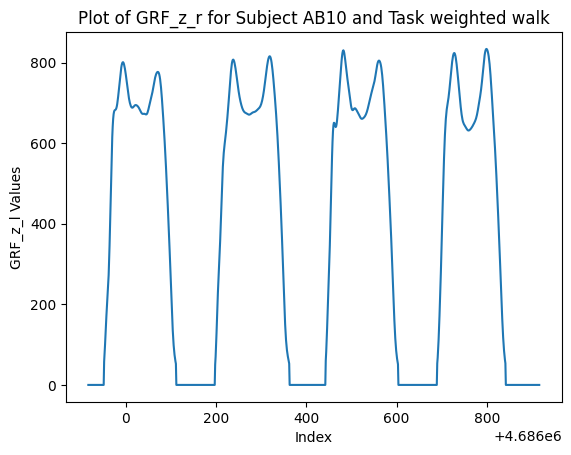

In [35]:
filtered_df = df[(df['subject'] == 'Gtech_2023_AB10') & (df['task'] == 'weighted_walk')]

# Plot the column COP_z_r
plt.plot(filtered_df['GRF_z_l'][0:1000])
plt.xlabel('Index')
plt.ylabel('GRF_z_l Values')
plt.title('Plot of GRF_z_r for Subject AB10 and Task weighted walk')
plt.show()

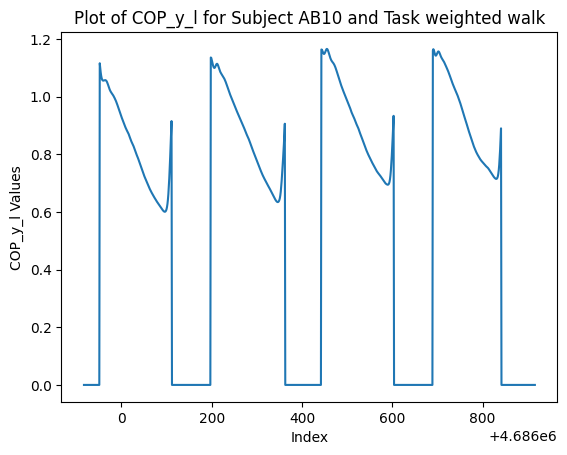

In [36]:
plt.plot(filtered_df['COP_y_l'][0:1000])
plt.xlabel('Index')
plt.ylabel('COP_y_l Values')
plt.title('Plot of COP_y_l for Subject AB10 and Task weighted walk')
plt.show()